In [1]:
from os.path import dirname, join as pjoin
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import networkx as nx   # https://github.com/networkx/networkx
import cpnet            # https://github.com/skojaku/core-periphery-detection
from tqdm import tqdm   # to show progressbar
from scipy.integrate import quad
from scipy import signal
from numpy.polynomial.polynomial import Polynomial as poly

def load_from_matlab(file, k, weight=True):
    """
    Input : 
    - file : (int) number of the file 
    - k = nb of clusters+2  (int between 1 and 8)
    - weighted graph (default) or not
    Output : 
    - nwin : number of time windows (int)
    - N : nb of neuron (int) 
    - theta, so values (int 1 & 2)
    - spec : Spectogram of the file (nwin,) list
    - Sharing : (nwin,) array with n° substate
    - RippleDensity_by_win : (nwin,) list
    - flat_adj : contains for each row the flattened adjency matrix for one period of time :  (nwin, N*(N-1)) array
    """
    File = 'File'+str(file)
    data_dir = '/mnt/c/Users/waked/OneDrive - CentraleSupelec/Documents/Stages INS/Ben/Data/'
    mat_clusters = pjoin(data_dir, 'Pascale data', 'ClusterData.C.Feat.HPC.REDO')
    ClusterData = sio.loadmat(mat_clusters)
    ClusterData = ClusterData['ClusterData']    
    ClusterData_file = ClusterData[File][0,0]
    spec = ClusterData_file['Spectrogram'][0,0]
    theta = ClusterData_file['IsTheta'][0,0] 
    theta = theta[0,0]
    so = 3-theta  # 2 if theta=1 and 1 if theta=2
    spec = spec['clust_feat'][0,0]
    spec = spec[:,0] 
    
    Sharing = ClusterData_file['Sharing'][0,0]
    Sharing = Sharing['clust'][0,0]
    if file==2 or file==3:
        Sharing = Sharing[k-1,:]  # Clusterization done only one time and not 3-times
    else:
        Sharing = Sharing[k-1,:,1]
    
    mat_RippleDensity =  pjoin(data_dir, 'useful outputs', 'AllRippleDensity_by_win')
    Ripples_win = sio.loadmat(mat_RippleDensity)
    AllRippleDensity_by_win = Ripples_win["AllRippleDensity_by_win"]
    Ripples_Pascale = AllRippleDensity_by_win['Pascale_data'][0,0]
    RippleDensity_by_win = Ripples_Pascale[File][0,0]
    RippleDensity_by_win = RippleDensity_by_win[0]
    
    mat_Features =  pjoin(data_dir, 'Pascale data', File, File+'_Features_HPC')
    Features = sio.loadmat(mat_Features)
    Features_Spikenet = Features['Features_Spikenet']
    nwin,N = np.shape(Features_Spikenet['SpikeDensity'][0,0])
    if weight: info = 'Graph_w'
    else: info = 'Graph'
    flat_adj = Features_Spikenet[info][0,0] #flattened adjency matrices 
    
    print("{} time-windows, {} neurons, so : {}, spec : {}, Sharing with {} clusters : {},  ".format(nwin, N, so,spec,k+2,Sharing))
    return nwin, N, theta, so, spec, Sharing, RippleDensity_by_win, flat_adj

def find(array, condition):
    """
    e>2 condition should for e.g be written:  lambda e: e>2 
    """
    return [i for i, elem in enumerate(array) if condition(elem)]

def delimitation_SO(spec,so):
    """
    
    """
    num_index = find(spec, lambda e: e==so)
    distance = np.diff(num_index) #distance between 2 SO index
    gaps = find(distance, lambda e: e>1) #find the gaps = zone of discontinuity (start of a new SO)
    starts = [] #assuming that max 6 blocks of SO
    ends = []
    starts.append(num_index[0])
    for i in range(len(gaps)): 
        starts.append(num_index[gaps[i]+1])
        ends.append(num_index[gaps[i]])
    ends.append(num_index[-1])
    return starts, ends

def dict_adj(N, flat_adj):
    """
    return a dictionnary of all Adj matrices for each time-window. 
    Keys are time-windows (start=0)
    Values are adjency matrices
    """
    def check_symmetric(a, rtol=1e-05, atol=1e-08):
        return np.allclose(a, a.T, rtol=rtol, atol=atol)
    
    nwin,_ = np.shape(flat_adj)
    Adjs = {} #dictionnary that stores adjency matrices for each window
    for t in tqdm(range(nwin)):  # Create a graph for each window of time
        flat_graph_t = flat_adj[t,:]
        flat_graph_t = np.insert(flat_graph_t,[N*i for i in range(N)],0)  #insert the value A(i,i) for each neuron : flattened adj matrix
        Adj_0 = np.reshape(flat_graph_t,(N,N)) # Adjency matrix
        # Checking the transformation
        c=0
        for i in range(N):
            if Adj_0[i,i] != 0:
                print("error for i=%d", i)
                c+=1
        if not(c==0 and check_symmetric(Adj_0)):
            print("error for win=%d", {t})
        Adjs[t] = Adj_0
    return Adjs

def Get_Hubs(region, file, F, St, Sh, selected_subsate):
  """
  - region : "HPC"
             "EC"
  - file : int 1 to 5
  - F/St/Sh : Number of substates for each feature
  - selected_subsate : (int) Chosen Sharing substate
  """  
  Hubs = sio.loadmat(r'/mnt/c/Users/waked/OneDrive - CentraleSupelec/Documents/Stages INS/Ben/Data/useful outputs/Hubs_P')
  Index = sio.loadmat(r'/mnt/c/Users/waked/OneDrive - CentraleSupelec/Documents/Stages INS/Ben/Data/useful outputs/Index_P')
  
  def clust2index(F,St,Sh):
    index = (F-3)*64+(St-3)*8+(Sh-3)
    return index
  index = clust2index(F,St,Sh)
  
  Hubs = Hubs['Hubs']  
  Hubs_R = Hubs['R'][0,0]
  Hubs_R = Hubs_R['HPC'][0,0]
  Hubs_R = Hubs_R['c'][0,0]
  Hubs_R = Hubs_R['neuron'][0,0]
  HR = Hubs_R[(file-1)*512:file*512]
  
  Hubs_SO = Hubs['SO'][0,0]
  Hubs_SO = Hubs_SO['HPC'][0,0]
  Hubs_SO = Hubs_SO['c'][0,0]
  Hubs_SO = Hubs_SO['neuron'][0,0]
  HSO = Hubs_SO[(file-1)*512:file*512]
  
  rip_n = HR[index,0]
  SO_n = HSO[index,0]
  hubs_rip = find(rip_n[:,F+St+selected_subsate-1], lambda e: e==1)
  hubs_SO = find(SO_n[:,F+St+selected_subsate-1], lambda e: e==1)
  both = []
  only_hubsRip = []
  only_hubsSO = []
  N,_ = np.shape(rip_n)
  not_hubs = list(range(N))
  for h in hubs_rip:
    not_hubs = np.delete(not_hubs, find(not_hubs, lambda e: e==h))
    if h in hubs_SO:
      both.append(h)
    else : 
      only_hubsRip.append(h)
  for h in hubs_SO:
    if not(h in hubs_rip):
      only_hubsSO.append(h)
      not_hubs = np.delete(not_hubs, find(not_hubs, lambda e: e==h))
      
  return only_hubsRip, only_hubsSO, both, not_hubs

def coreness(Adjs):
    """
     Parameters ---------
    - nwin; number of time-windows
    - N: number of neurons
    - Adjs: dic
            keys are the time of each windows and values are adjency matrix for that time.
     Returns ---------
    - CORE: array (time windows, nb of neuron)
          rows show the coreness for time window t for each neuron (column) 
    """
    nwin = len(Adjs) #nb of time windows
    N,_ = np.shape(Adjs[0]) #nb of neuron
    CORE = np.zeros((nwin,N))
    print("Computing coreness . . .")
    for time in tqdm(range(nwin)):
        G = nx.Graph(Adjs[time]) # transform adj matrix into nx graph object
        algo = cpnet.Rossa() #Load the algorithm
        algo.detect(G) # Give the network as an input
        coreness = algo.get_coreness()  # Get the coreness of nodes
        # pair = algo.get_pair_id()  # Get the group membership of nodes
        CORE[time,:] = list(coreness.values())
    return CORE    

def complete(n):  #all to all network
  x = range(1,n+1)
  y = n*[0]
  for i in range(n):
    y[i] = i/(n-1)
  new_series = poly.fit(x,y,deg=20)
  coef = new_series.convert().coef
  complete = poly(coef)
  return complete

def star(n):  #only one node connected to all others
  x = range(1,n+1)
  y = (n-1)*[0]
  y.append(1)
  new_series = poly.fit(x,y,deg=20)
  coef = new_series.convert().coef
  star = poly(coef)
  return star

def cp_profile(n, coreness):
  x = range(1,n+1)
  y = np.sort(coreness)
  new_series = poly.fit(x,y,deg=20)
  coef = new_series.convert().coef
  f = poly(coef)
  return f

def cp_centralisation(CORE,time2plot):
  """
  Parameters ---------
    - CORE: array (nb of time-windows, nb of neurons)
            for each time window, returns the coreness of each neuron (meaningful only if high cp-centralisation)
    - time2plot: (int) value between 0 and nwin to display cp-centralisation
  Returns ---------
    - C : list (nb time windows)
          cp-centralisation 
  """
  nwin,N = np.shape(CORE)
  C = nwin*[0]
  print("Computing cp-centralisation . . .")
  for time in tqdm(range(nwin)): 
    f_complete = complete(N)
    f_star = star(N)
    f = cp_profile(N,CORE[time,:])
    res, _= quad(f, 1, N)
    resC, _ = quad(f_complete, 1, N)
    resS,_ = quad(f_star, 1, N)
    C[time] = (resC-res)/(resC-resS)  #cp-centralisation between 0 (like complete) and 1 (like star)
  if time == time2plot:
    X = np.linspace(1,N,100)
    fig = plt.figure()
    plt.plot(f_complete(X))
    plt.plot(f(X),'green')
    plt.plot(f_star(X),'r')
    plt.xticks(range(1,N+1))
    plt.legend(['Complete : ' + str(round(resC,3)), 'Network : ' + str(round(res,3)), 'Star : ' + str(round(resS,3))])
  return np.array(C)

def Jacccard_similarity(Adjs):
    """
    Parameters ---------
    - Adjs: dic
            keys are the time of each windows and values are adjency matrix for that time.
    Returns ---------
    - J : array (time windows-1, nb of neuron)
          rows show the Jaccard similarity for time window t and t+1 for each neuron 
          jaccard distance = 1-J
    """
    nwin = len(Adjs) #nb of time windows
    N,_ = np.shape(Adjs[0]) #nb of neuron
    J = np.zeros((nwin-1,N)) 
    for time in range(nwin-1):
        adj_t0 = Adjs[time]
        adj_t1 = Adjs[time+1]
        for i in range(N): # for each neuron
            ni_t0 = adj_t0[i,:]
            ni_t1 = adj_t1[i,:]
            num = (ni_t0*ni_t1).sum()
            den =  (ni_t0+ni_t1)
            den[den==2]=1
            den = den.sum()
            J[time,i] = num/den
    return J

def cosine_similarity(Adjs):
    """
    Parameters
    ---------
    - Adjs: dic
            keys are the time of each windows and values are adjency matrix for that time.
    Returns
    ---------
    - COS : array (time windows-1, nb of neuron)
          rows show the Jaccard similarity for time window t and t+1 for each neuron 
          jaccard distance = 1-J
    """
    nwin = len(Adjs) #nb of time windows
    N,_ = np.shape(Adjs[0]) #nb of neuron
    COS = np.zeros((nwin-1,N)) 
    print("Computing cosine similarity . . .")
    for time in tqdm(range(nwin-1)):
        adj_t0 = Adjs[time]
        adj_t1 = Adjs[time+1]
        for i in range(N): # for each neuron
            ni_t0 = adj_t0[i,:]
            ni_t1 = adj_t1[i,:]
            num = (ni_t0*ni_t1).sum()
            den =  np.sqrt(np.sum(ni_t0**2)*np.sum(ni_t1**2))
            COS[time,i] = num/den
    return COS

def plot_liquidity(spec, so, COS, Sharing, neurons ='all', subs =[1,2,3,4], show_curve = False):
    """
    - neuron : 'all' : display the average liquidity over all neurons
                [x,y,z] (list of int) : display the average liquidity over selected neurons
    """
    _,N = np.shape(COS)
    starts, ends = delimitation_SO(spec, so)
    nb_periods = len(starts)
    fig, ax = plt.subplots(ncols = 2, figsize=(20,7), gridspec_kw={'width_ratios': [10, 1]})
    ax[0].set_title('Liquidity')
    for i in range(nb_periods):
        if i==0:
            ax[0].axvspan(xmin=starts[i], xmax = ends[i] , facecolor='yellow', alpha=0.2)  # legend appears only once
        else : 
            ax[0].axvspan(xmin=starts[i], xmax = ends[i] , facecolor='yellow', alpha=0.2, label='_nolegend_')
    legend = ['SWS']
    
    project_L = []
    colors = ['blue', 'orange', 'green', 'red']
    ax[1].vlines(1,0,1)  # Draw a horizontal line
    for i in range(len(subs)):
        idx_sub = find(Sharing, lambda e:e==subs[i])
        idx_sub.pop()
        cos_sub = COS[idx_sub,:]
        if neurons=='all':
            cos_sub = np.nanmean(cos_sub,axis=1)  #average of liquidity over all neurons
            project_L.append(np.nanmean(cos_sub))
            title = 'Average liquidity of all neurons'
        else :
            cos_sub = np.nanmean(cos_sub[:,neurons],axis=1)
            project_L.append(np.nanmean(cos_sub))
            title = 'Average liquidity of neurons n° {}'.format(neurons)
        ax[0].scatter(idx_sub, cos_sub, s=5)
        ax[1].eventplot([project_L[i]], orientation='vertical', colors=colors[i],  linelengths=.4, linewidths=5)
        legend.append('sub'+str(i+1))
    ax[0].set_ylim([.6,1])
    ax[0].legend(legend)
    ax[0].set_title(title)
    
    print(project_L)
    ## 
    # Plot smooth black curves for each neuron
    if show_curve:
        if neurons=='all': 
            neurons = range(N)   
        nwin = len(Sharing)
        smooth_step = 100 # 1 point is the average coreness of 100 time-windows
        bins = range(0,nwin,smooth_step)  #smooth curve
        for n in neurons:
            smooth_liq = []
            for bin in bins:
                if bin+smooth_step>nwin:
                    smooth_liq.append(np.nanmean(COS[bin:,n],axis=0))
                else:
                    smooth_liq.append(np.nanmean(COS[bin:bin+smooth_step,n],axis=0))
            if n in range(17,18):  # n=17 # n=8  #n=29
                color = 'fuchsia'
            else: 
                color='k'
            ax[0].plot(range(0,nwin,smooth_step), smooth_liq, color=color, label='_nolegend_' )
        ax[0].set_ylim([.6,1])
        ax[0].set_title('liquidity for each neuron')
        ax[0].set_ylabel('Liquidity')
    
        # project_L.append(np.mean(COS[Sharing==sub, neurons]))
    ax[1] = plt.gca()
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(True)
    ax[1].set_xlim([0.6,1.4])
    ax[1].set_ylim(list(ax[0].get_ylim()))
    
def plot_coreness(file, spec, so, CORE, Sharing, selected_hub_substate, neurons = 'all',  subs =[1,2,3,4] ):
    """
    - CORE : array (nwin,N) coreness values for each neuron
    - neuron : 'all' : display the average coreness over all neurons
                [x,y,z] (list of int) : display the average coreness over selected neurons
    """
    _,N = np.shape(CORE)
    starts, ends = delimitation_SO(spec, so)
    nb_periods = len(starts)
    fig, ax = plt.subplots(figsize=(15,6))
    for i in range(nb_periods):
        if i==0:
            ax.axvspan(xmin=starts[i], xmax = ends[i] , facecolor='yellow', alpha=0.3)  # legend appears only once
        else : 
            ax.axvspan(xmin=starts[i], xmax = ends[i] , facecolor='yellow', alpha=0.3, label='_nolegend_')
    legend = ['SWS']
    # for i in range(len(subs)):
    #     idx_sub = find(Sharing, lambda e:e==subs[i]) # index when sharing = subs i
    #     core_sub = CORE[idx_sub,:]  
    #     if neurons=='all':
    #         core_sub = np.nanmean(core_sub,axis=1)  #average of liquidity over all neurons
    #         title = 'Average coreness of all neurons'
    #     else :
    #         print(np.shape(core_sub[:,neurons]))
    #         core_sub = np.nanmean(core_sub[:,neurons],axis=1)
    #         title = 'Average coreness of neurons n° {}'.format(neurons)
    #     ax[0].scatter(idx_sub, core_sub,s=5)
    #     legend.append('sub'+str(i))
    # ax[0].legend(legend)
    # ax[0].set_title(title)
    ## 
    # Plot smooth black curves for each neuron$
    hubs_rip, hubs_SO, both, not_hubs = Get_Hubs( "HPC", file=file, F=4, St=3, Sh=4, selected_subsate=selected_hub_substate) # Get Hubs
    if neurons=='all': 
        neurons = range(N)   
    nwin = len(Sharing)
    smooth_step = 100 # 1 point is the average coreness of 100 time-windows
    bins = range(0,nwin,smooth_step)  #smooth curve
    for type, hub_list in enumerate([hubs_rip, hubs_SO, both, not_hubs]):
        smooth_core = []
        avg_hubs_core = np.nanmean(CORE[:,hub_list],axis=1)
        for bin in bins:
            if bin+smooth_step>nwin:
                smooth_core.append(np.nanmean(avg_hubs_core[bin:],axis=0))
            else:
                smooth_core.append(np.nanmean(avg_hubs_core[bin:bin+smooth_step],axis=0))
        if type == 0 :  # n=17 # n=8  #n=29
            color = 'red'
            print("Hubs only in ripples: ", hub_list)
        elif type == 1: 
            color = 'green'
            print("Hubs only in SO: ", hub_list)
        elif type == 2 : 
            color = 'orange'
            print("Hubs in both: ", hub_list)
        else :
            color = 'b'
            print("Not Hubs: ", hub_list)
        ax.plot(range(0,nwin,smooth_step), smooth_core, color=color )
    ax.set_title('Coreness for types of hubs')
    ax.set_ylabel('Coreness')
    ax.legend(['hubs in ripples only', 'hubs in SO only', 'hubs in both', 'not hubs'], loc='upper right')
    
def plot_centralisation(spec, so, C, Sharing, subs =[1,2,3,4]):
    """
    - C : (list) nwin - value of cp-centralisation between 0 and 1 for each time-window
    """
    nwin = len(C)
    C = np.array(C)
    starts, ends = delimitation_SO(spec, so)
    nb_periods = len(starts)
    fig, ax = plt.subplots(ncols = 2, figsize=(20,7), gridspec_kw={'width_ratios': [10, 1]})
    ax[0].set_title('cp-centralisation')
    for i in range(nb_periods):
        if i==0:
            ax[0].axvspan(xmin=starts[i], xmax = ends[i] , facecolor='yellow', alpha=0.3)  # legend appears only once
        else : 
            ax[0].axvspan(xmin=starts[i], xmax = ends[i] , facecolor='yellow', alpha=0.3, label='_nolegend_')
    legend = ['cp-centralisation']
    legend.append('SWS')
    for i in range(len(subs)):
        idx_sub = find(Sharing, lambda e:e==subs[i]) # index when sharing = subs i
        C_sub = C[idx_sub]  
        ax[0].scatter(idx_sub, C_sub, s=5)
        legend.append('sub'+str(i+1))
    ## 
    # Plot smooth black curve
    smooth_step = 100 # 1 point is the average coreness of 100 time-windows
    bins = range(0,nwin,smooth_step)  #smooth curve
    smooth_C = []
    for bin in bins:
        if bin+smooth_step>nwin:
            smooth_C.append(np.mean(C[bin:]))
        else:
            smooth_C.append(np.mean(C[bin:bin+smooth_step]))
    ax[0].plot(range(0,nwin,smooth_step), smooth_C, 'k')
    ax[0].legend(legend)
    ax[0].set_ylim(ax[0].get_ylim())
    
    project_C = []
    colors = ['blue', 'orange', 'green', 'red']
    ax[1].vlines(1,0,1)  # Draw a horizontal line
    for sub in [1,2,3,4]:
        project_C.append(np.mean(C[Sharing==sub]))
        ax[1].eventplot([project_C[sub-1]], orientation='vertical', colors=colors[sub-1],  linelengths=.4, linewidths=5)
    ax[1] = plt.gca()
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(True)
    ax[1].set_xlim([0.6,1.4])
    ax[1].set_ylim(list(ax[0].get_ylim()))
     
def correlation_ripples(spec, so, RippleDensity_by_win, Sharing, CORE, C, selected_neurons):
    subs = np.unique(Sharing)
    # for s in subs:
    C = np.array(C)
    x = RippleDensity_by_win[spec==so]
    yC= C[spec==so]
    CORE_so = CORE[spec==so, :]
    ycore = np.nanmean(CORE_so[:,selected_neurons],axis=1)
    corr_C0 = np.corrcoef(x, yC)
    corr_core0 = np.corrcoef(x,ycore )
    corr_C = signal.correlate(x, yC)
    corr_core = signal.correlate(x, ycore)
    return corr_C0[0,1], corr_core0[0,1], corr_C, corr_core
    

7190 time-windows, 37 neurons, so : 2, spec : [1 1 1 ... 1 1 1], Sharing with 4 clusters : [1 1 1 ... 2 2 2],  
[1800, 2400, 6825] [2099, 4949, 6899]


100%|██████████| 7190/7190 [00:01<00:00, 4503.33it/s]


Computing cosine similarity . . .


  0%|          | 0/7189 [00:00<?, ?it/s]/tmp/ipykernel_283/3785104163.py:296: RuntimeWarning: invalid value encountered in double_scalars
  COS[time,i] = num/den
100%|██████████| 7189/7189 [00:05<00:00, 1228.61it/s]


Computing coreness . . .


100%|██████████| 7190/7190 [01:15<00:00, 95.18it/s]
/tmp/ipykernel_283/3785104163.py:324: RuntimeWarning: Mean of empty slice
  cos_sub = np.nanmean(cos_sub,axis=1)  #average of liquidity over all neurons


[0.9047113583773302, 0.8842293261197307, 0.8843553289353747, 0.9158099903791151]
Hubs only in ripples:  [19, 35]
Hubs only in SO:  [20, 22, 27]
Hubs in both:  [0, 1, 8, 11, 12, 17, 23, 29, 36]
Not Hubs:  [ 2  3  4  5  6  7  9 10 13 14 15 16 18 21 24 25 26 28 30 31 32 33 34]
Computing cp-centralisation . . .


  0%|          | 0/7190 [00:00<?, ?it/s]/tmp/ipykernel_283/3785104163.py:232: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res, _= quad(f, 1, N)
/tmp/ipykernel_283/3785104163.py:234: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  resS,_ = quad(f_star, 1, N)
  0%|          | 4/7190 [00:00<07:49, 15.30it/s]/tmp/ipykernel_283/3785104163.py:232: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improv

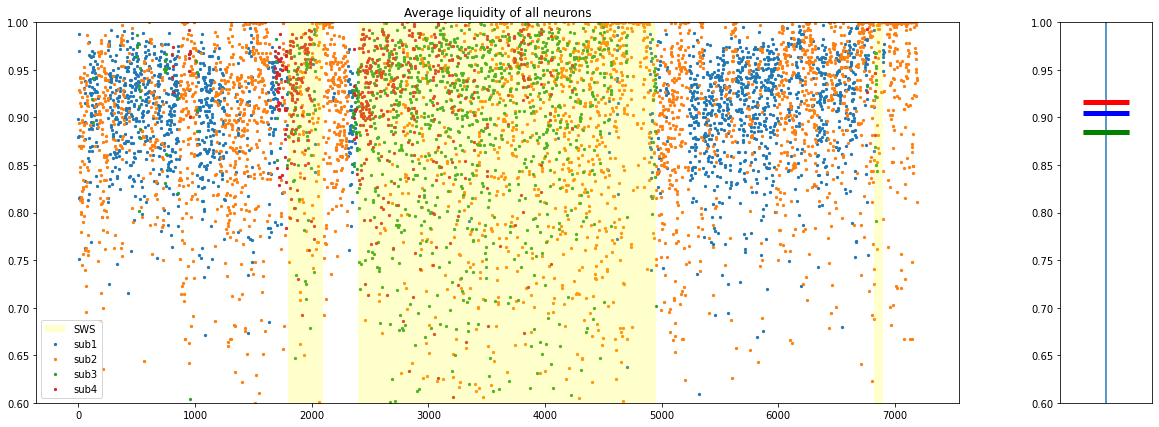

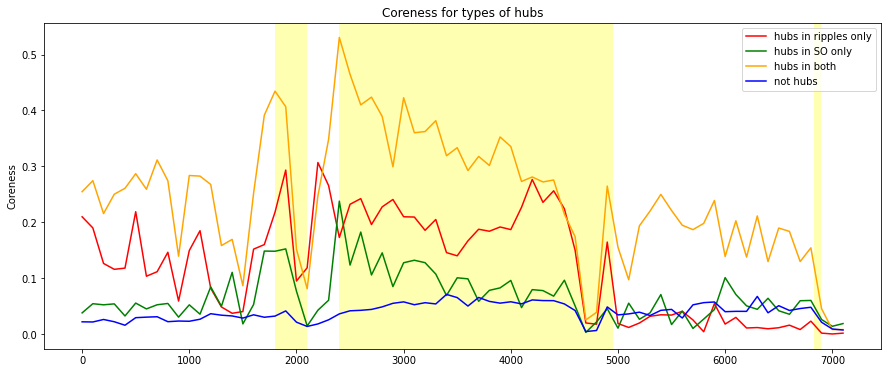

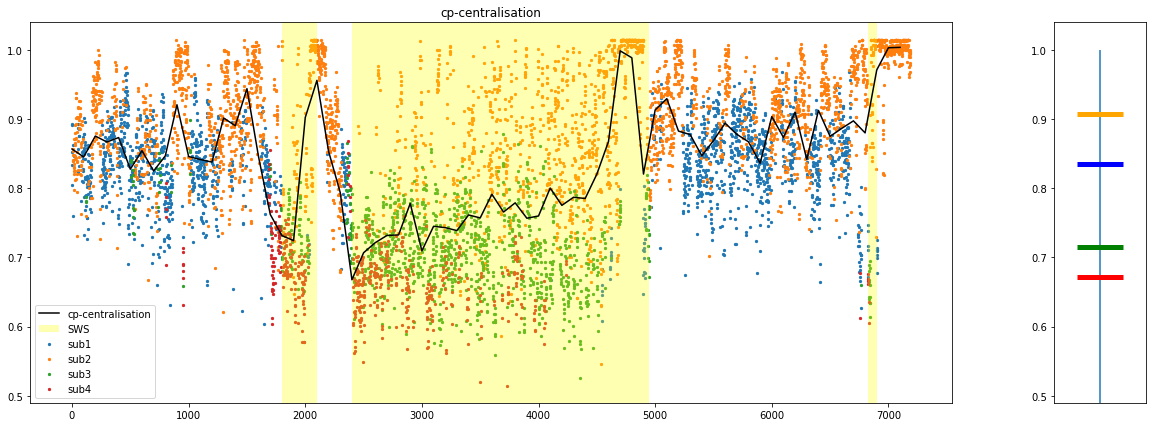

In [2]:
file = 4
nwin, N, theta, so, spec, Sharing, RippleDensity_by_win, flat_adj = load_from_matlab(file=file, k=2, weight=True)
starts, ends = delimitation_SO(spec, so)
print(starts, ends)
Adjs = dict_adj(N, flat_adj)
COS = cosine_similarity(Adjs)
CORE = coreness(Adjs)
idx = find(Sharing,lambda e:e==4) # idx where substates == 4
hubs_rip, hubs_SO, both, not_hubs = Get_Hubs( "HPC", file=file, F=4, St=3, Sh=4, selected_subsate=3)
# ____________________________ plots
fig = plot_liquidity(spec, so, COS, Sharing, neurons='all', subs =[1,2,3,4], show_curve = False)
fig = plot_coreness(file, spec, so, CORE, Sharing, selected_hub_substate=4, neurons='all', subs =[1,2,3,4])
C = cp_centralisation(CORE, time2plot=1000)
fig = plot_centralisation(spec, so, C, Sharing, subs=[1,2,3,4])
plt.show()
# ____________________________ Compute correlation
# corr_C0, corr_core0, corr_C, corr_core = correlation_ripples(spec, so, RippleDensity_by_win, Sharing, CORE, C, selected_neurons=hubs_rip)
# # print(corr_C0, corr_core0, corr_C, corr_core)


In [ ]:
def spanning_tree(Adjs):
  for time in range(nwin):
    G = nx.Graph(Adjs[time]) # transform adj matrix into nx graph object
    d = nx.density(G)
    
  

0.028528528528528527
[[0, 5, 8], [1, 2, 6, 7, 9], [3, 4]]
red
violet
green
['red', 'violet', 'violet', 'green', 'green', 'red', 'violet', 'violet', 'red', 'violet']


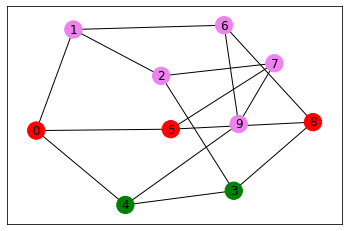

In [118]:
G = nx.Graph(Adjs[5]) # transform adj matrix into nx graph object
print(nx.density(G))
import networkx.algorithms.community as nx_comm
Gb = nx.barbell_graph(5, 1)
G = nx.petersen_graph()
subset_color = [
    "red",
    "violet",
    "green",
    "orange",
]
communities_generator = nx_comm.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
comm = sorted(map(sorted, next_level_communities))
print(comm)
colors = 10*[0]
for i, group in enumerate(comm):
    group_color = subset_color[i]
    print(group_color)
    for node in group:
        colors[node] = group_color
print(colors)
nx.draw_networkx(G,node_color=colors)

In [99]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx

subset_sizes = [5, 5, 4, 3, 2, 4, 4, 3]
subset_color = [
    "gold",
    "violet",
    "violet",
    "violet",
    "violet",
    "limegreen",
    "limegreen",
    "darkorange",
]


def multilayered_graph(*subset_sizes):
    extents = nx.utils.pairwise(itertools.accumulate((0,) + subset_sizes))
    layers = [range(start, end) for start, end in extents]
    G = nx.Graph()
    for (i, layer) in enumerate(layers):
        G.add_nodes_from(layer, layer=i)
    for layer1, layer2 in nx.utils.pairwise(layers):
        G.add_edges_from(itertools.product(layer1, layer2))
    return G

G = multilayered_graph(*subset_sizes)
color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]
print(color)
pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_color=color, with_labels=False)
plt.axis("equal")
plt.show()

NameError: name 'data' is not defined

# Mutual information 

In [89]:
from sklearn.neighbors import KernelDensity
import numpy as np
rng = np.random.RandomState(42)
kde = KernelDensity( bandwidth=0.2).fit(x[:,None])

In [131]:
X = np.linspace(x.min(),x.max(),20)
plt.plot( X, 10**(kde.score_samples(X[:,None]) ) )

c, n= np.histogram(x, 15, normed=True)

p=c/c.sum()

H = []
for pi in p:
  out = pi*np.log2(1/pi)
  print(out)
  if out != np.inf and out != np.nan: 
    H+=[out]

0.2/np.nansum(H)

0.10593199379153576

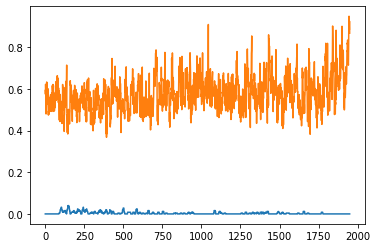

In [232]:
# plt.plot(range(len(corr_C)), corr_C)
# plt.plot(range(len(corr_core)), corr_core)
plt.plot(range(1950), RippleDensity_by_win[spec==so])
Carr = np.array(C)
plt.plot(range(1950), Carr[spec==so])
# np.max(corr_C)

(array([ 14., 207., 644., 828., 681., 484., 434., 484., 474., 370.]),
 array([0.34936619, 0.41617918, 0.48299216, 0.54980514, 0.61661812,
        0.6834311 , 0.75024408, 0.81705706, 0.88387005, 0.95068303,
        1.01749601]),
 <BarContainer object of 10 artists>)

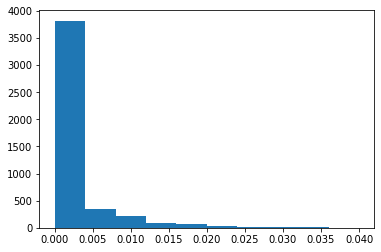

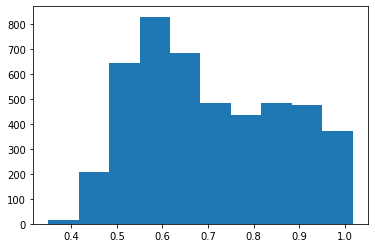

In [34]:
plt.hist(RippleDensity_by_win, bins = 10, log = 0)
plt.figure()
plt.hist(C)

2.0429297697404656

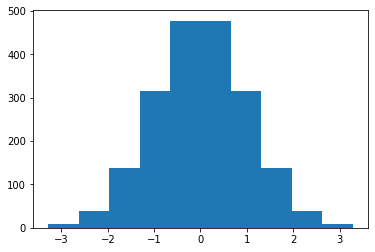

In [144]:
f_x = copnorm_1d(x)
plt.hist(f_x)
H = ent_1d_g(f_x)
H

In [162]:
from frites.core import gcmi_1d_cc, ent_1d_g, copnorm_1d

def normed_mi_copula(x,y):
  # f_x = copnorm_1d(x)  #find the copula distribution of x
  # f_y = copnorm_1d(y)  #find the copula distribution of y
  # h_x = ent_1d_g(f_x)  
  # h_y = ent_1d_g(f_y)
  norm_MI = gcmi_1d_cc(x,y)
  rd_mi = [] 
  for i in range(100):
    yrand = y.copy()
    np.random.shuffle(yrand)
    rd_mi+=[gcmi_1d_cc(x,yrand)]
  surrogate = np.nanquantile(rd_mi, 0.90)  # choose 0.99 percentile value of the surrogate 
  return norm_MI, surrogate

normed_mi_copula(C[spec==so], RippleDensity_by_win[spec==so])

(3.768748033653011e-06, 0.0005309657581628123)

In [ ]:
def normed_mi_hand(x,y):
  def joint_probablity(x,y):
    
    return Pxy
  
  def entropy(p):
    H = []
    for pi in p:
      out = np.log2(1/pi)
      print(out)
      if out != np.inf and out != np.nan: 
        H+=[out/len(p)] # empirical mean <x> = sum(x_i)/N
    return H 
      
  
  rd_mi = [] 
  for i in range(100):
    yrand = y.copy()
    np.random.shuffle(yrand)
    rd_mi+=[gcmi_1d_cc(x,yrand)]
  surrogate = np.nanquantile(rd_mi, 0.90)  # choose 0.99 percentile value of the surrogate 
  return norm_MI, surrogate

mi = []
for i in range(100):


# Distribution of node degree

100%|██████████| 7190/7190 [00:02<00:00, 2941.96it/s]


[1.5666e+04 5.3250e+03 3.7610e+03 2.8820e+03 2.6940e+03 2.3360e+03
 2.1940e+03 1.9240e+03 1.9000e+03 1.6840e+03 1.5800e+03 1.4440e+03
 1.2330e+03 9.8700e+02 8.7100e+02 6.8500e+02 5.9100e+02 4.4800e+02
 3.7300e+02 2.2000e+02 1.6100e+02 8.4000e+01 4.2000e+01 3.0000e+01
 9.0000e+00 5.0000e+00 3.0000e+00 4.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00]
[3.18829372e-01 1.08372680e-01 7.65426571e-02 5.86535331e-02
 5.48274178e-02 4.75415174e-02 4.46515793e-02 3.91566265e-02
 3.86681863e-02 3.42722240e-02 3.21556496e-02 2.93878216e-02
 2.50936177e-02 2.00871052e-02 1.77263106e-02 1.39408987e-02
 1.20278411e-02 9.11755129e-03 7.59117551e-03 4.47736894e-03
 3.27661999e-03 1.70954087e-03 8.54770433e-04 6.10550309e-04
 1.83165093e-04 1.01758385e-04 6.10550309e-05 8.14067079e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


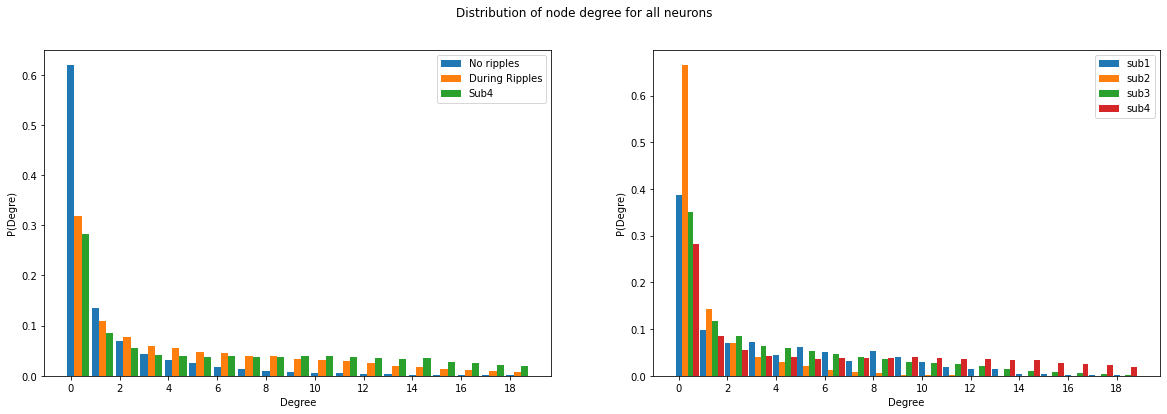

In [278]:
thr = 0.0 
deg_hist_norip = np.zeros(N)  # Total histogram over all neurons and all time windows
deg_hist_rip = np.zeros(N)
deg_hist_subs = np.zeros((N,k+2))  # ith column contains the histogram for substate i

for time in tqdm(range(nwin)):
    G = nx.Graph(Adjs[time]) # transform adj matrix into nx graph object
    deg_hist_t = nx.degree_histogram(G)  # histogram for only the time window
    
    if RippleDensity_by_win[time]>thr:  # window containing ripples
        for idx, number in enumerate(deg_hist_t):
            deg_hist_rip[idx] += number
    elif spec[time]==so :   # window in SWS not containing ripples
        for idx, number in enumerate(deg_hist_t):                        
            deg_hist_norip[idx] += number
            
    for i in range(1,k+3):
        if spec[time]==so and Sharing[time]==i:
            for idx, number in enumerate(deg_hist_t):
                deg_hist_subs[idx,i-1] += number

print(deg_hist_rip)
# Get rid of all degrees after one being too little
deg_hist_norip = deg_hist_norip/sum(deg_hist_norip)
deg_hist_rip = deg_hist_rip/sum(deg_hist_rip)

print(deg_hist_rip)
n=0
while deg_hist_rip[n]>0.005:
    n+=1

deg_hist_norip = np.delete(deg_hist_norip, range(n,N))
deg_hist_rip = np.delete(deg_hist_rip, range(n,N))

x = np.arange(len(deg_hist_norip))

# plot data
fig,axs = plt.subplots(1,2,figsize=(20, 6))
fig.suptitle('Distribution of node degree for all neurons')
# axs = plt.gca()

width=.24
for i in range(k+2):
    deg_hist_subs[:,i] = deg_hist_subs[:,i]/sum(deg_hist_subs[:,i])
    axs[1].bar(x+i*width, deg_hist_subs[:n,i], width=width)
axs[1].set_xticks(range(0,n,2))
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('P(Degre)')
axs[1].legend(['sub1','sub2','sub3','sub4'])

width = .3
axs[0].bar(x, deg_hist_norip, width=width)
axs[0].bar(x+width, deg_hist_rip, width=width)
axs[0].bar(x+2*width, deg_hist_subs[:n,3], width=width)
axs[0].set_xticks(range(0,n,2))
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('P(Degre)')
axs[0].legend(['No ripples','During Ripples','Sub4'])

# Distribution of coreness  (cpnet module)

In [133]:
thr = 0.0
k=2
Core_rip = np.array([]) #coreness of all neurons
Core_norip = np.array([]) 
Core_subs = 4*[np.array([])]

for time in tqdm(range(nwin)):
    G = nx.Graph(Adjs[time]) # transform adj matrix into nx graph object
    algo = cpnet.Rossa() #Load the algorithm
    algo.detect(G) # Give the network as an input
    coreness = algo.get_coreness()  # Get the coreness of nodes
    pair = algo.get_pair_id()  # Get the group membership of nodes
    C = list(coreness.values())
    if RippleDensity_by_win[time]>thr:  # window containing ripples
        Core_rip = np.append(Core_rip,C)
    elif spec[time]==so :   # window in SWS not containing ripples
        Core_norip = np.append(Core_norip,C)
    for i in range(1,k+3):
        if spec[time] == so and Sharing[time]==i:
            Core_subs[i-1] = np.append(Core_subs[i-1],C)

100%|██████████| 7190/7190 [04:29<00:00, 26.64it/s]


0.8571428571428571

/home/ben/Documents/INS/Graph_Analysis/environments/graph_analysis/lib/python3.8/site-packages/numpy/polynomial/polynomial.py:1336: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


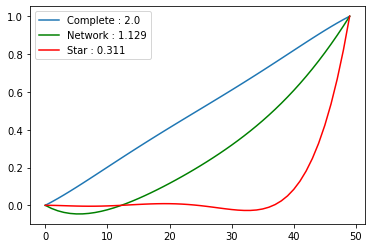

In [193]:
from scipy.integrate import quad
from numpy.polynomial.polynomial import Polynomial as poly

def complete(n):  #all to all network
  x = range(1,n+1)
  y = n*[0]
  for i in range(n):
    y[i] = i/(n-1)
  new_series = poly.fit(x,y,deg=n)
  coef = new_series.convert().coef
  complete = poly(coef)
  return complete

def star(n):  #only one node connected to all others
  x = range(1,n+1)
  y = (n-1)*[0]
  y.append(1)
  new_series = poly.fit(x,y,deg=n)
  coef = new_series.convert().coef
  star = poly(coef)
  return star

def cp_profile(n,coreness):
  x = range(1,n+1)
  y = np.sort(list(coreness.values()))
  new_series = poly.fit(x,y,deg=n)
  coef = new_series.convert().coef
  f = poly(coef)
  return f




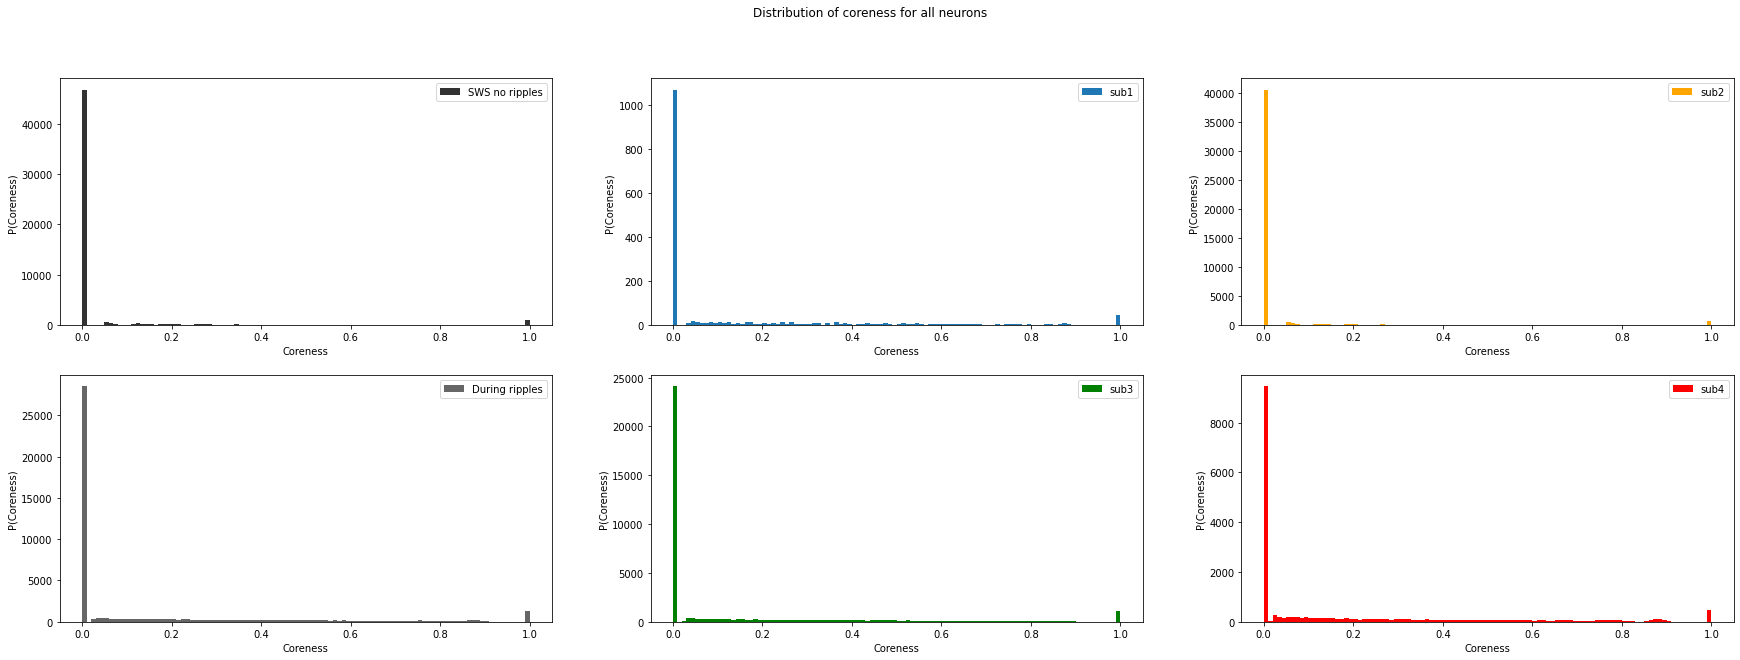

In [134]:
# plot data
fig,axs = plt.subplots(2,3,figsize=(30, 10))
fig.suptitle('Distribution of coreness for all neurons')

# Get rid of 0-coreness
# Core_rip[Core_rip==0] = 'nan'
# Core_norip[Core_norip==0] = 'nan'
# for i in range(4):
#   Core_subs[i][Core_subs[i]==0]='nan'
#___________________________

axs[0,0].hist(Core_norip,100,density=False,color=[.2,.2,.2])
axs[0,0].set_xlabel('Coreness')
axs[0,0].set_ylabel('P(Coreness)')
axs[0,0].legend(['SWS no ripples'])

axs[1,0].hist(Core_rip,100,color=[.4,.4,.4],density=False)
axs[1,0].set_xlabel('Coreness')
axs[1,0].set_ylabel('P(Coreness)')
axs[1,0].legend(['During ripples'])

axs[0,1].hist(Core_subs[0],100,density=False)
axs[0,1].set_xlabel('Coreness')
axs[0,1].set_ylabel('P(Coreness)')
axs[0,1].legend(['sub1'])

axs[0,2].hist(Core_subs[1],100,color='orange',density=False)
axs[0,2].set_xlabel('Coreness')
axs[0,2].set_ylabel('P(Coreness)')
axs[0,2].legend(['sub2'])

axs[1,1].hist(Core_subs[2],100,color='green',density=False)
axs[1,1].set_xlabel('Coreness')
axs[1,1].set_ylabel('P(Coreness)')
axs[1,1].legend(['sub3'])

axs[1,2].hist(Core_subs[3], 100, color='r',density=False)
axs[1,2].set_xlabel('Coreness')
axs[1,2].set_ylabel('P(Coreness)')
axs[1,2].legend(['sub4'])


# How coreness of a node evolves with its degree ?

100%|██████████| 7190/7190 [32:25<00:00,  3.70it/s]


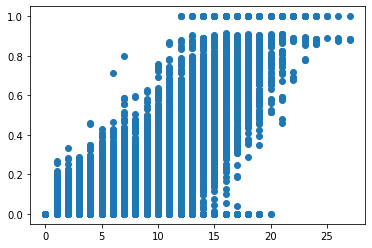

In [216]:

idx = []
Degs = []
Sig_Coreness=[]
Coreness =[]
for i in tqdm(range(nwin)):
    if Sharing[i]==4:
        idx.append(i)    
        Gsub4 = nx.Graph(Adjs[i])
        algo = cpnet.Rossa()
        algo.detect(Gsub4)
        coreness = algo.get_coreness()
        pair = algo.get_pair_id()
        sig_pair, sig_core, significant, p_values = cpnet.qstest(pair, coreness, Gsub4, algo, significance_level = 0.05, num_of_thread = 4)
        for node in range(N):
            Degs.append(Gsub4.degree(node)) 
            Sig_Coreness.append(sig_core[node])
            Coreness.append(coreness[node])


# print("coreness : ",coreness)
# print("pair ID : ",pair)
# ax = plt.gca()
# print(ax)
# pos=nx.spring_layout(Gsub4, scale=15)
# ax, pos = cpnet.draw(Gsub4, pair, coreness, ax, font_size=12, draw_labels_kwd={'labels':labels})
# Gsub4.degree(8)


(array([1.1271e+04, 2.9000e+01, 2.9700e+02, 2.2700e+02, 1.8500e+02,
        2.4100e+02, 1.8200e+02, 2.2300e+02, 1.8400e+02, 1.7800e+02,
        1.9800e+02, 1.7000e+02, 1.8000e+02, 1.6900e+02, 1.7900e+02,
        1.3900e+02, 1.5600e+02, 1.6100e+02, 1.4500e+02, 1.3600e+02,
        1.3400e+02, 1.3800e+02, 1.1400e+02, 1.3200e+02, 1.3500e+02,
        1.3100e+02, 1.0600e+02, 1.1000e+02, 1.1400e+02, 1.1200e+02,
        1.1600e+02, 1.0700e+02, 1.0300e+02, 1.0000e+02, 1.0400e+02,
        9.4000e+01, 9.2000e+01, 9.0000e+01, 9.5000e+01, 1.0400e+02,
        8.8000e+01, 8.3000e+01, 8.1000e+01, 7.7000e+01, 8.8000e+01,
        7.6000e+01, 8.4000e+01, 9.0000e+01, 8.3000e+01, 6.8000e+01,
        6.1000e+01, 8.0000e+01, 7.3000e+01, 6.4000e+01, 7.6000e+01,
        6.5000e+01, 6.1000e+01, 6.8000e+01, 6.8000e+01, 8.4000e+01,
        4.9000e+01, 6.2000e+01, 7.5000e+01, 5.0000e+01, 4.8000e+01,
        6.6000e+01, 7.7000e+01, 7.1000e+01, 6.2000e+01, 4.8000e+01,
        4.7000e+01, 5.9000e+01, 3.9000e+01, 3.60

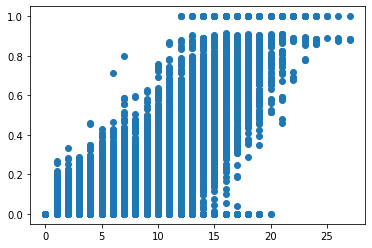

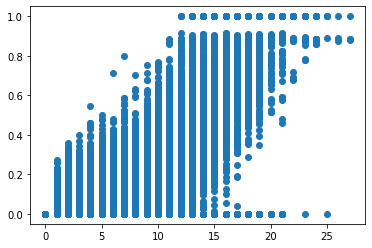

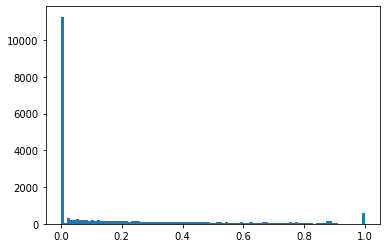

In [266]:
plt.figure() 
plt.scatter(Degs,Sig_Coreness)
plt.figure()
plt.scatter(Degs,Coreness)
plt.figure()
plt.hist(Coreness,100)

In [246]:
idx_None=np.array([])
for i in range(len(Sig_Coreness)):
    if Sig_Coreness[i]==None:
        idx_None = np.append(idx_None,i)
        
print(len(idx_None), len(np.unique(idx_None//37)),np.unique(idx_None//37) )

3552 96 [  3.  15.  37.  43.  49.  51.  62.  64.  67.  68.  78.  96.  97.  98.
  99. 108. 115. 116. 121. 133. 138. 146. 174. 186. 187. 188. 200. 218.
 220. 235. 236. 238. 248. 251. 255. 274. 280. 285. 287. 288. 295. 297.
 305. 318. 319. 320. 321. 322. 323. 324. 325. 328. 337. 348. 350. 355.
 356. 362. 363. 365. 366. 367. 370. 371. 373. 374. 376. 377. 380. 387.
 398. 400. 412. 414. 415. 417. 439. 440. 443. 445. 450. 452. 455. 460.
 465. 468. 469. 471. 476. 479. 481. 486. 488. 490. 506. 530.]


## Plotting graph showing coreness and colored pair groups

100%|██████████| 300/300 [00:23<00:00, 12.91it/s]


[False] [0.2689828279076769]
{0: None, 1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12: None, 13: None, 14: None, 15: None, 16: None, 17: None, 18: None, 19: None, 20: None, 21: None, 22: None, 23: None, 24: None, 25: None, 26: None, 27: None, 28: None, 29: None, 30: None, 31: None, 32: None, 33: None, 34: None, 35: None, 36: None} {0: None, 1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12: None, 13: None, 14: None, 15: None, 16: None, 17: None, 18: None, 19: None, 20: None, 21: None, 22: None, 23: None, 24: None, 25: None, 26: None, 27: None, 28: None, 29: None, 30: None, 31: None, 32: None, 33: None, 34: None, 35: None, 36: None}


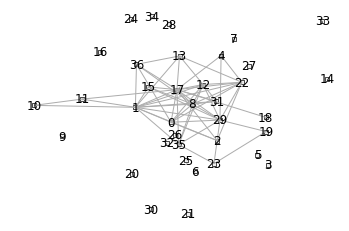

In [194]:
G_test = nx.Graph(Adjs[idx[0]])
algo = cpnet.Rossa()
algo.detect(G_test)
coreness = algo.get_coreness()
pair = algo.get_pair_id()
sig_pair, sig_core, significant, p_values = cpnet.qstest(pair, coreness, G_test, algo, significance_level = 0.05, num_of_thread = 16)
# pos = nx.spring_layout(G, scale = 2)  # The position can be calculated and passed to the drawing function
#labels
labels={}
for node in range(N):
    labels[node] = node

fig = plt.figure()
ax = plt.gca()

ax, pos = cpnet.draw(
    G_test,
    sig_pair,
    sig_core,
    ax,
    # draw_nodes_kwd={"node_size": 30, "linewidths": 0.3},
    # max_colored_group_num=3,
    draw_edge=True,
    font_size=12,
    # layout_kwd = {"verbose":True, "iterations":500}
    draw_labels_kwd={'labels':labels}
)
print(significant, p_values)
print(sig_core, sig_pair)

[[0 0 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 0 1 1 1 0]
 [0 1 0 0 0 1 1 1 1 1]
 [1 0 1 1 0 0 0 1 1 0]
 [1 1 1 0 1 1 0 1 0 0]
 [1 0 1 0 1 0 1 0 0 0]
 [0 0 0 1 1 1 1 1 1 1]
 [0 1 1 0 1 0 1 1 0 1]
 [0 1 0 1 0 1 1 1 1 0]
 [0 0 1 0 0 0 0 0 1 0]]
{0: 0.7090909090909091, 1: 0.2903225806451613, 2: 1.0, 3: 0.1111111111111111, 4: 0.09090909090909091, 5: 0.17391304347826086, 6: 0.8615384615384616, 7: 0.45, 8: 0.6041666666666666, 9: 0.0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}


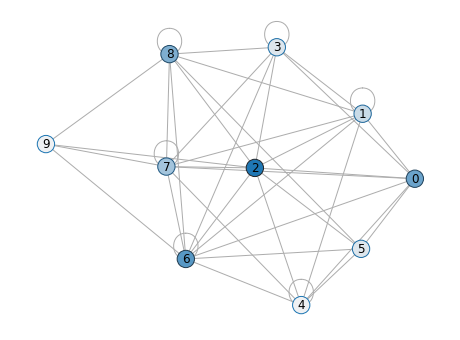

In [275]:
a = np.random.randint(0, 2, size=(10, 10))
print(a)
D = nx.Graph(a)
algo = cpnet.Rossa() #Load the KM algorithm
algo.detect(D) # Give the network as an input
x = algo.get_coreness()  # Get the coreness of nodes
c = algo.get_pair_id()  # Get the group membership of nodes
print(x)
print(c)
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
label_a = {}
for i in range(10):
    label_a[i] = i
ax, _ = cpnet.draw(D, c, x, ax,font_size=12,draw_labels_kwd={'labels':label_a} )



[0.0, 0.06997084548104955, 0.13702623906705538, 0.20116618075801748, 0.26239067055393583, 0.32069970845481044, 0.3760932944606414, 0.4285714285714286, 0.478134110787172, 0.5247813411078717, 0.5685131195335276, 0.6093294460641399, 0.6472303206997084, 0.6822157434402332, 0.7142857142857143, 0.7434402332361515, 0.7696793002915452, 0.793002915451895, 0.8134110787172011, 0.8309037900874636, 0.8454810495626821, 0.8571428571428571, 0.8658892128279883, 0.8717201166180758, 0.8746355685131195, 0.8746355685131195, 0.8717201166180758, 0.8658892128279884, 0.8571428571428572, 0.8454810495626821, 0.8309037900874636, 0.8134110787172012, 0.7930029154518952, 0.7696793002915453, 0.7434402332361516, 0.7142857142857144, 0.6822157434402334, 0.6472303206997085, 0.6093294460641401, 0.5685131195335279, 0.5247813411078719, 0.47813411078717216, 0.4285714285714287, 0.37609329446064144, 0.3206997084548108, 0.2623906705539361, 0.2011661807580177, 0.13702623906705552, 0.06997084548104963, 0.0]


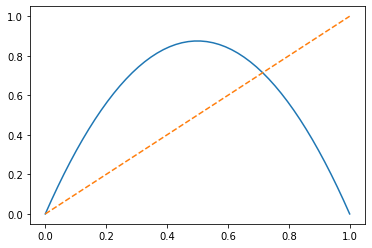

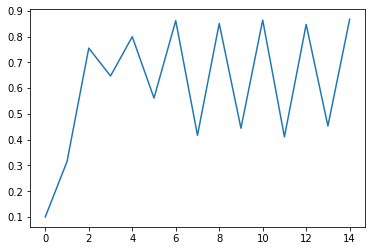

In [38]:
# Chaos theory
def x(n,x0,r):
  if n==0: 
    return x0
  else:
    return r*x(n-1,x0,r)*(1-x(n-1,x0,r))
  
x0 = 0.1
r = 3.5
N = 15 #samples
evolu_x = [x(n,x0,r) for n in range(N)]
evolu_x0 = [x(1,x0,r) for x0 in np.linspace(0,1)]
print(evolu_x0)
plt.plot(np.linspace(0,1), evolu_x0)
plt.plot(np.linspace(0,1),np.linspace(0,1),'--')
plt.figure()
plt.plot(range(N), evolu_x)
                          